In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Input, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
s_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/static_train_data_median.csv')
s_holdout = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/static_holdout_data_median.csv')
s_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/static_test_data_median.csv')
d_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/dynamic_train_median.csv')
d_holdout = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/dynamic_holdout_median.csv')
d_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPH6004/assign/Simple median imputed/dynamic_test_median.csv')

In [ ]:
# d_train = d_train.sort_values(by=['id','charttime'])
# d_holdout = d_holdout.sort_values(by=['id','charttime'])
# d_test = d_test.sort_values(by=['id','charttime'])

In [ ]:
# s_train['icu_los_group'] = pd.cut(s_train['los_icu'], bins=[-np.inf, 2.5, 5, np.inf], labels=[0, 1, 2])
# s_holdout['icu_los_group'] = pd.cut(s_holdout['los_icu'], bins=[-np.inf, 2.5, 5, np.inf], labels=[0, 1, 2])
# s_test['icu_los_group'] = pd.cut(s_test['los_icu'], bins=[-np.inf, 2.5, 5, np.inf], labels=[0, 1, 2])
s_train['icu_los_group'] = s_train['los_icu'].apply(lambda x: 0 if x <= 7 else 1)
s_holdout['icu_los_group'] = s_holdout['los_icu'].apply(lambda x: 0 if x <= 7 else 1)
s_test['icu_los_group'] = s_test['los_icu'].apply(lambda x: 0 if x <= 7 else 1)


In [ ]:
columns_to_convert = ['hosp_admittime', 'hosp_dischtime', 'icu_intime','icu_outtime']

for column in columns_to_convert:
    s_train[column] = pd.to_datetime(s_train[column])
    s_test[column] = pd.to_datetime(s_test[column])
    s_holdout[column] = pd.to_datetime(s_holdout[column])
d_train['charttime'] = pd.to_datetime(d_train['charttime'])
d_test['charttime'] = pd.to_datetime(d_test['charttime'])
d_holdout['charttime'] = pd.to_datetime(d_holdout['charttime'])

<ipython-input-96-845b6cd82fbb>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_train[column] = pd.to_datetime(s_train[column])
<ipython-input-96-845b6cd82fbb>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_test[column] = pd.to_datetime(s_test[column])
<ipython-input-96-845b6cd82fbb>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_holdout[column] = pd.to_datetime(s_holdout[column])
<ipython-input-96-845b6cd82fbb>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-e

In [ ]:
# merged_train = pd.merge(d_train, s_train, on='id', how='left')
# merged_test = pd.merge(d_test, s_test, on='id', how='left')
# merged_holdout = pd.merge(d_holdout, s_holdout, on='id', how='left')
# merged_train['hour'] = (merged_train['charttime'] - merged_train['icu_intime']).dt.total_seconds() / 3600
# merged_test['hour'] = (merged_test['charttime'] - merged_test['icu_intime']).dt.total_seconds() / 3600
# merged_holdout['hour'] = (merged_holdout['charttime'] - merged_holdout['icu_intime']).dt.total_seconds() / 3600

In [ ]:
# d_train = pd.merge(d_train, merged_train[['id', 'hour']], on='id', how='left')
# d_holdout = pd.merge(d_holdout, merged_holdout[['id', 'hour']], on='id', how='left')
# d_test = pd.merge(d_test, merged_test[['id', 'hour']], on='id', how='left')

In [ ]:
d_train = d_train.sort_values(by=['id','charttime'])
d_holdout = d_holdout.sort_values(by=['id','charttime'])
d_test = d_test.sort_values(by=['id','charttime'])
s_train.sort_values(by=['id'])
s_holdout.sort_values(by=['id'])
s_test.sort_values(by=['id'])

,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,los_icu,icu_death,gender,race,admission_age,...,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),icu_los_group
3581,20001770,2017-01-25 19:12:00,2017-02-09 16:40:00,2017-01-25 20:47:00,2017-01-28 17:35:00,2.87,0,0,WHITE,35.067900,...,0,0,0,0,0,0,0,1,0,0
528,20004357,2057-08-05 10:57:00,2057-08-12 18:00:00,2057-08-05 12:22:00,2057-08-08 20:03:00,3.32,0,0,BLACK/AFRICAN AMERICAN,77.594051,...,0,0,1,0,0,0,0,0,0,0
2557,20008098,1975-02-06 00:00:00,1975-02-14 13:50:00,1975-02-09 14:21:00,1975-02-12 00:33:00,2.42,0,1,WHITE,76.098077,...,0,0,0,0,0,0,0,1,0,0
31,20013839,2018-07-07 06:16:00,2018-07-12 14:45:00,2018-07-07 07:30:00,2018-07-09 17:43:00,2.43,0,0,WHITE,65.512704,...,0,0,0,0,0,0,0,0,1,0
529,20015722,2042-02-18 02:27:00,2042-02-28 16:30:00,2042-02-18 03:18:00,2042-02-20 17:45:00,2.60,0,1,WHITE,27.131699,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556,29991038,2036-03-25 16:21:00,2036-04-08 18:15:00,2036-03-26 14:39:00,2036-04-02 21:11:00,7.27,0,0,BLACK/AFRICAN AMERICAN,78.230612,...,0,1,0,0,0,0,0,0,0,1
1018,29991213,2020-09-07 18:23:00,2020-09-10 14:00:00,2020-09-07 18:48:00,2020-09-09 18:29:00,1.99,0,1,WHITE,85.685912,...,0,1,0,0,0,0,0,0,0,0
527,29994296,2033-04-16 16:54:00,2033-05-13 13:45:00,2033-04-29 12:21:00,2033-05-01 21:15:00,2.37,0,1,WHITE,87.291484,...,0,0,0,1,0,0,0,0,0,0
3047,29996630,1988-11-24 01:54:00,1988-12-18 16:50:00,1988-11-24 16:01:00,1988-11-29 18:51:00,5.12,0,0,WHITE - OTHER EUROPEAN,55.897764,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
y_train = s_train['icu_los_group'].values
y_holdout = s_holdout['icu_los_group'].values
y_test = s_test['icu_los_group'].values
X_train = s_train.drop(columns=['los_icu','icu_outcome','icu_death','icu_los_group'], axis=1)
X_holdout = s_holdout.drop(columns=['los_icu','icu_outcome','icu_death','icu_los_group'],axis = 1)
X_test = s_test.drop(columns=['los_icu','icu_outcome','icu_death','icu_los_group'], axis=1)

In [ ]:
X_train

,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,gender,race,admission_age,weight_admit,height,...,admission_type_URGENT,first_careunit_Cardiac Vascular Intensive Care Unit (CVICU),first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU)
0,24099382,2011-06-11 07:15:00,2011-06-18 21:45:00,2011-06-11 14:31:00,2011-06-13 18:05:00,1,OTHER,58.441631,92.0,170.0,...,0,0,0,0,0,0,0,0,0,1
1,27824879,2028-09-30 20:55:00,2028-10-10 15:54:00,2028-09-30 20:58:00,2028-10-05 18:39:00,0,WHITE,79.748598,55.0,170.0,...,0,0,0,0,0,0,0,0,0,1
2,27146619,2041-09-20 00:34:00,2041-09-22 12:05:00,2041-09-20 07:13:00,2041-09-21 18:10:00,0,WHITE,81.717397,59.0,170.0,...,0,0,0,0,1,0,0,0,0,0
3,23169158,2027-03-12 01:19:00,2027-03-19 13:15:00,2027-03-12 02:43:00,2027-03-15 01:53:00,0,WHITE,84.191979,79.1,160.0,...,0,0,0,0,1,0,0,0,0,0
4,22717922,2065-01-14 17:50:00,2065-02-11 14:25:00,2065-01-14 17:52:00,2065-01-31 14:08:00,0,PORTUGUESE,58.039790,61.5,150.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29964937,1989-10-02 23:54:00,1989-10-06 18:58:00,1989-10-03 01:49:00,1989-10-05 17:17:00,0,WHITE,75.754989,94.6,170.0,...,0,0,0,0,1,0,0,0,0,0
14285,29968077,2059-09-12 06:20:00,2059-10-05 15:41:00,2059-09-12 07:45:00,2059-09-18 16:55:00,1,WHITE,73.695489,122.2,170.0,...,0,0,1,0,0,0,0,0,0,0
14286,29975784,2036-08-30 15:18:00,2036-09-02 16:15:00,2036-08-30 16:48:00,2036-09-01 10:41:00,1,WHITE,86.663745,69.3,170.0,...,0,0,0,0,1,0,0,0,0,0
14287,29987115,2048-02-16 17:42:00,2048-02-20 19:00:00,2048-02-16 17:43:00,2048-02-20 21:00:00,0,UNKNOWN,43.127963,67.0,152.0,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 44 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   id                                                               14289 non-null  int64         
 1   hosp_admittime                                                   14289 non-null  datetime64[ns]
 2   hosp_dischtime                                                   14289 non-null  datetime64[ns]
 3   icu_intime                                                       14289 non-null  datetime64[ns]
 4   icu_outtime                                                      14289 non-null  datetime64[ns]
 5   gender                                                           14289 non-null  int64         
 6   race                                                             14289 non-nul

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_numeric = X_train.select_dtypes(exclude=['object','datetime']).drop(columns=['id'])
X_holdout_numeric = X_holdout.select_dtypes(exclude=['object','datetime']).drop(columns=['id'])
X_test_numeric = X_test.select_dtypes(exclude=['object','datetime']).drop(columns=['id'])
# 对数据进行归一化处理
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_holdout_scaled = scaler.fit_transform(X_holdout_numeric)
X_test_scaled = scaler.fit_transform(X_test_numeric)
# 将归一化后的数据转换为 NumPy 数组
X_train = np.array(X_train_scaled)
X_holdout = np.array(X_holdout_scaled)
X_test = np.array(X_test_scaled)
X_train

array([[1.        , 0.4927806 , 0.09018831, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.75246682, 0.05351833, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.77646226, 0.05748266, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.83674763, 0.06769078, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.30613984, 0.0654113 , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.73799791, 0.07086224, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
s_train.columns

Index(['id', 'hosp_admittime', 'hosp_dischtime', 'icu_intime', 'icu_outtime',
       'los_icu', 'icu_death', 'gender', 'race', 'admission_age',
       'weight_admit', 'height', 'charlson_score', 'atrial_fibrillation',
       'malignant_cancer', 'chf', 'ckd', 'cld', 'copd', 'diabetes',
       'hypertension', 'ihd', 'stroke', 'icu_outcome', 'race_encode_African',
       'race_encode_Asian', 'race_encode_Caucasian', 'race_encode_Hispanic',
       'race_encode_Not Specified', 'race_encode_South American',
       'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'first_careunit_Cardiac Vascular Intensive Care Unit (CVICU)',
       'first_careunit_Coronary Care Unit (CCU)',
       'first_careunit_Medical Intensive Care Unit (MICU)',
       'first_careunit_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_seq(data, timestep):

    columns_to_keep = [col for col in data.columns if col not in ['id', 'charttime']]

    grouped_data = data.groupby('id')[columns_to_keep]

    scaler = MinMaxScaler()


    time_series = []

    for group_name, group_data in grouped_data:
        if len(group_data) >= timestep:
            scaled_data = scaler.fit_transform(group_data.iloc[-timestep:])
            time_series.append(scaled_data)
        else:
            padding_rows = timestep - len(group_data)
            repeated_data = np.tile(group_data.values[0], (padding_rows, 1))
            combined_data = np.vstack([repeated_data, group_data.values])
            scaled_data = scaler.fit_transform(combined_data)
            time_series.append(scaled_data)
    time_series_array = np.array(time_series)
    #time_series_array = time_series_array.transpose(1, 0, 2)

    return time_series_array


In [ ]:
timestep = 5

In [ ]:
d_train_seq = create_seq(d_train, timestep)
d_holdout_seq = create_seq(d_holdout, timestep)
d_test_seq = create_seq(d_test, timestep)

In [ ]:
d_train_seq.shape

(14289, 5, 21)

In [ ]:
X_train.shape

(14289, 38)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_holdout_encoded = label_encoder.transform(y_holdout)

In [ ]:
from keras.layers import TimeDistributed, Bidirectional, LSTM, Dense, Dropout, Input, Concatenate
from keras.models import Model
#from keras_self_attention import SeqSelfAttention

static_input = Input(shape=(X_train.shape[1],))
dynamic_input = Input(shape=(timestep, d_train_seq.shape[2]))
lstm_output = Bidirectional(LSTM(units=256, activation='tanh', dropout=0.2, recurrent_dropout=0.2))(dynamic_input)
#attention = SeqSelfAttention(attention_activation='sigmoid')(lstm_output)
concatenated = Concatenate()([static_input, lstm_output])

dense_output1 = Dense(units=256, activation='relu')(concatenated)
dropout_output1 = Dropout(0.5)(dense_output1)
dense_output2 = Dense(units=128, activation='relu')(dropout_output1)
dropout_output2 = Dropout(0.2)(dense_output2)
dense_output3 = Dense(units=64, activation='relu')(dropout_output2)
dropout_output3 = Dropout(0.2)(dense_output3)
dense_output4 = Dense(units=32, activation='relu')(dropout_output3)

output = Dense(units=3, activation='softmax')(dense_output4)

model = Model(inputs=[static_input, dynamic_input], outputs=output)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit([X_train, d_train_seq], y_train_encoded, validation_data=([X_holdout, d_holdout_seq], y_holdout_encoded), epochs=20, batch_size=128)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:

y_pred = model.predict([X_test, d_test_seq])



test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", test_rmse)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred

In [ ]:
y_test

Epoch 1/20
112/112 [==============================] - 33s 176ms/step - loss: 0.4797 - accuracy: 0.8225 - val_loss: 0.4601 - val_accuracy: 0.8247
Epoch 2/20
112/112 [==============================] - 16s 141ms/step - loss: 0.4673 - accuracy: 0.8225 - val_loss: 0.4562 - val_accuracy: 0.8247
Epoch 3/20
112/112 [==============================] - 15s 135ms/step - loss: 0.4634 - accuracy: 0.8225 - val_loss: 0.4562 - val_accuracy: 0.8247
Epoch 4/20
112/112 [==============================] - 16s 140ms/step - loss: 0.4621 - accuracy: 0.8225 - val_loss: 0.4565 - val_accuracy: 0.8247
Epoch 5/20
112/112 [==============================] - 16s 140ms/step - loss: 0.4619 - accuracy: 0.8225 - val_loss: 0.4583 - val_accuracy: 0.8247
Epoch 6/20
112/112 [==============================] - 15s 138ms/step - loss: 0.4586 - accuracy: 0.8225 - val_loss: 0.4604 - val_accuracy: 0.8247
Epoch 7/20
112/112 [==============================] - 16s 145ms/step - loss: 0.4588 - accuracy: 0.8225 - val_loss: 0.4585 - val_ac

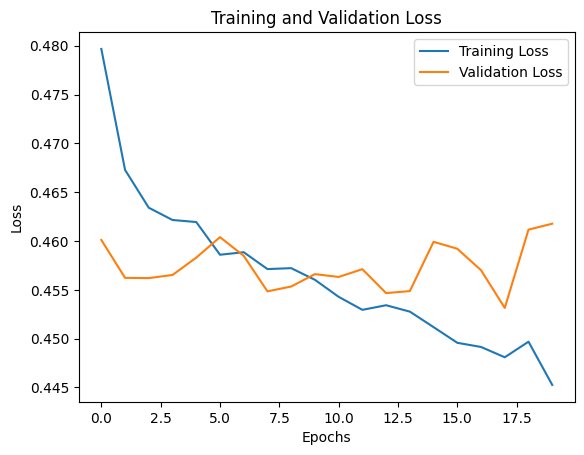

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score


y_train_cat = to_categorical(y_train, num_classes=2)
y_holdout_cat = to_categorical(y_holdout, num_classes=2)

static_input = Input(shape=(X_train.shape[1],))
dynamic_input = Input(shape=(timestep, d_train_seq.shape[2]))

lstm_output = Bidirectional(LSTM(units=256, activation='tanh', dropout=0.2, recurrent_dropout=0.2))(dynamic_input)

attention = Attention()([lstm_output, lstm_output])

concatenated = Concatenate()([static_input, attention])

dense_output1 = Dense(units=256, activation='relu')(concatenated)
dropout_output1 = Dropout(0.5)(dense_output1)
dense_output2 = Dense(units=128, activation='relu')(dropout_output1)
dropout_output2 = Dropout(0.2)(dense_output2)
dense_output3 = Dense(units=64, activation='relu')(dropout_output2)
dropout_output3 = Dropout(0.2)(dense_output3)
dense_output4 = Dense(units=32, activation='relu')(dropout_output3)
output = Dense(units=2, activation='sigmoid')(dense_output4)

model = Model(inputs=[static_input, dynamic_input], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit([X_train, d_train_seq], y_train_cat, validation_data=([X_holdout, d_holdout_seq], y_holdout_cat), epochs=20, batch_size=128)

y_pred = model.predict([X_test, d_test_seq])

y_pred_class = np.argmax(y_pred, axis=1)
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred_class)
print("Test Accuracy:", test_accuracy)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred_holdout = model.predict([X_holdout, d_holdout_seq])
y_pred_class = np.argmax(y_pred_holdout, axis=1)

test_accuracy = accuracy_score(y_holdout, y_pred_class)

report = classification_report(y_holdout, y_pred_class)

print(test_accuracy)

64/64 [==============================] - 2s 25ms/step
0.8207639569049952


In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

y_train_binary = (y_train > 7).astype(int)
y_holdout_binary = (y_holdout > 7).astype(int)

static_input = Input(shape=(X_train.shape[1],))
dynamic_input = Input(shape=(timestep, d_train_seq.shape[2]))

lstm_output = Bidirectional(LSTM(units=256, activation='tanh', dropout=0.2, recurrent_dropout=0.2))(dynamic_input)

attention = Attention()([lstm_output, lstm_output])

concatenated = Concatenate()([static_input, attention])

dense_output1 = Dense(units=256, activation='relu')(concatenated)
dropout_output1 = Dropout(0.5)(dense_output1)
dense_output2 = Dense(units=128, activation='relu')(dropout_output1)
dropout_output2 = Dropout(0.2)(dense_output2)
dense_output3 = Dense(units=64, activation='relu')(dropout_output2)
dropout_output3 = Dropout(0.2)(dense_output3)
dense_output4 = Dense(units=32, activation='relu')(dropout_output3)
output = Dense(units=1, activation='sigmoid')(dense_output4)  # 输出层修改为1个单元，并使用sigmoid激活函数

model = Model(inputs=[static_input, dynamic_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([X_train, d_train_seq], y_train_binary, validation_data=([X_holdout, d_holdout_seq], y_holdout_binary), epochs=20, batch_size=128)

y_pred = model.predict([X_test, d_test_seq])

y_pred_binary = (y_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", test_accuracy)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
